In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
activity_df = pd.read_csv('dailyActivity_merged.csv')
hr_df = pd.read_csv('heartrate_seconds_merged.csv')


In [5]:
print(activity_df.head())
print(hr_df.head())
print(activity_df.info())
print(activity_df.describe())
print(activity_df.columns)




           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366    3/25/2016       11004           7.11             7.11   
1  1503960366    3/26/2016       17609          11.55            11.55   
2  1503960366    3/27/2016       12736           8.53             8.53   
3  1503960366    3/28/2016       13231           8.93             8.93   
4  1503960366    3/29/2016       12041           7.85             7.85   

   LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
0                       0.0                2.57                      0.46   
1                       0.0                6.92                      0.73   
2                       0.0                4.66                      0.16   
3                       0.0                3.19                      0.79   
4                       0.0                2.16                      1.09   

   LightActiveDistance  SedentaryActiveDistance  VeryActiveMinutes  \
0                 4.07

In [23]:
activity_cleaned = activity_df[[
    'ActivityDate', 'TotalSteps', 'TotalDistance', 'VeryActiveMinutes', 'Calories'
]].copy() # Add .copy() here to work on a copy

# Convert 'ActivityDate' to datetime format
activity_cleaned['ActivityDate'] = pd.to_datetime(activity_cleaned['ActivityDate'])

# Preview cleaned data
print("\n✅ Cleaned Daily Activity Data:")
print(activity_cleaned.head())


✅ Cleaned Daily Activity Data:
  ActivityDate  TotalSteps  TotalDistance  VeryActiveMinutes  Calories
0   2016-03-25       11004           7.11                 33      1819
1   2016-03-26       17609          11.55                 89      2154
2   2016-03-27       12736           8.53                 56      1944
3   2016-03-28       13231           8.93                 39      1932
4   2016-03-29       12041           7.85                 28      1886


In [7]:
hr_df['Time'] = pd.to_datetime(hr_df['Time'])
hr_df.rename(columns={'Value': 'HeartRate'}, inplace=True)

# Drop NaNs and duplicates just in case
hr_df.dropna(inplace=True)
hr_df.drop_duplicates(inplace=True)

# Preview cleaned heart rate data
print("\n✅ Cleaned Heart Rate Data:")
print(hr_df.head())



✅ Cleaned Heart Rate Data:
           Id                Time  HeartRate
0  2022484408 2016-04-01 07:54:00       93.0
1  2022484408 2016-04-01 07:54:05       91.0
2  2022484408 2016-04-01 07:54:10       96.0
3  2022484408 2016-04-01 07:54:15       98.0
4  2022484408 2016-04-01 07:54:20      100.0


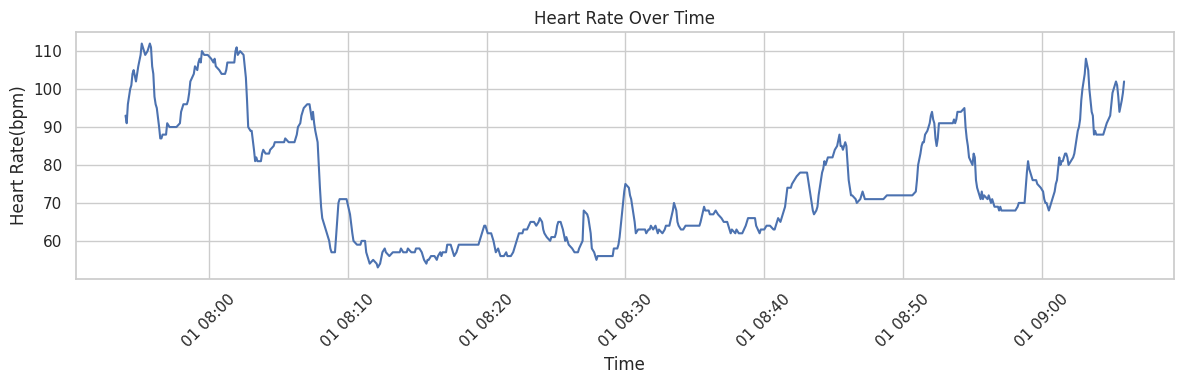

In [12]:
sample_hr=hr_df.head(500)
plt.figure(figsize=(12,4))
sns.lineplot(data=sample_hr,x='Time',y='HeartRate')
plt.title('Heart Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate(bpm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

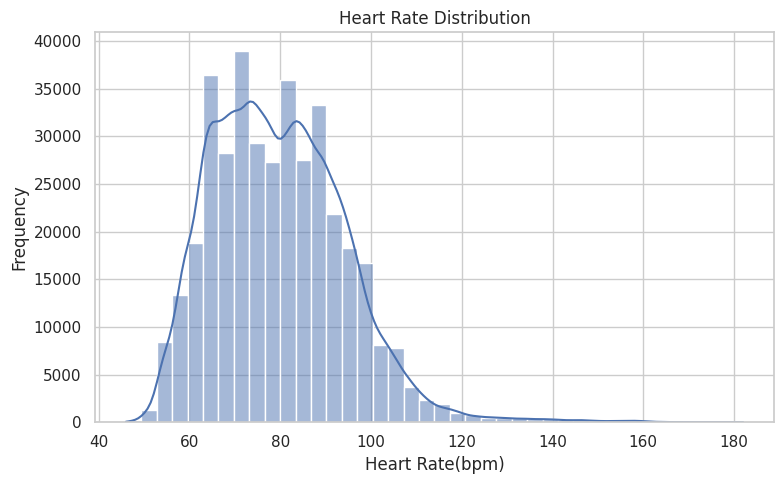

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(hr_df['HeartRate'],bins=40,kde=True)
plt.title('Heart Rate Distribution')
plt.xlabel('Heart Rate(bpm)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [14]:
# Flag heart rate > 100 as abnormal
hr_df['Status'] = hr_df['HeartRate'].apply(lambda x: 'abnormal' if x > 100 else 'normal')

# View some results
print(hr_df[['Time', 'HeartRate', 'Status']].head(10))

# Count abnormal readings
abnormal_counts = hr_df['Status'].value_counts()
print("\nAbnormal vs Normal Readings:\n", abnormal_counts)


                 Time  HeartRate    Status
0 2016-04-01 07:54:00       93.0    normal
1 2016-04-01 07:54:05       91.0    normal
2 2016-04-01 07:54:10       96.0    normal
3 2016-04-01 07:54:15       98.0    normal
4 2016-04-01 07:54:20      100.0    normal
5 2016-04-01 07:54:25      101.0  abnormal
6 2016-04-01 07:54:30      104.0  abnormal
7 2016-04-01 07:54:35      105.0  abnormal
8 2016-04-01 07:54:45      102.0  abnormal
9 2016-04-01 07:54:55      106.0  abnormal

Abnormal vs Normal Readings:
 Status
normal      355663
abnormal     28629
Name: count, dtype: int64


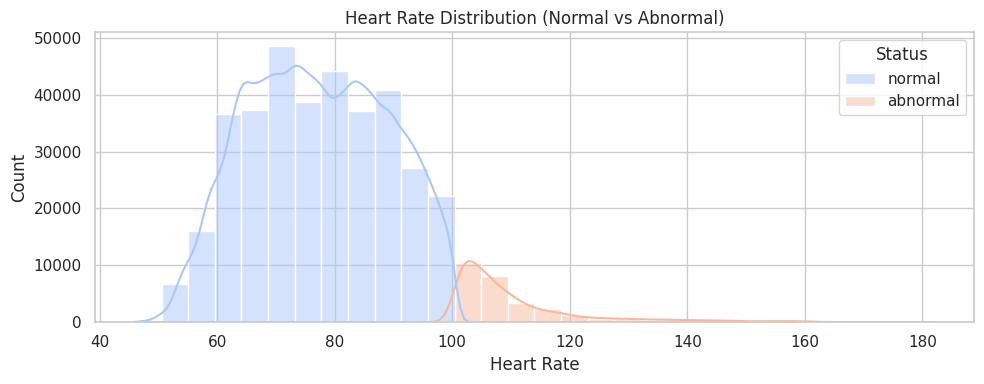

In [15]:
plt.figure(figsize=(10, 4))
sns.histplot(data=hr_df, x='HeartRate', hue='Status', bins=30, kde=True, palette='coolwarm')
plt.title('Heart Rate Distribution (Normal vs Abnormal)')
plt.xlabel('Heart Rate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [16]:
# Flag days with very low activity
activity_cleaned['StepStatus'] = activity_cleaned['TotalSteps'].apply(lambda x: 'inactive' if x < 1000 else 'active')

# Count
print(activity_cleaned['StepStatus'].value_counts())

# See inactive days
print(activity_cleaned[activity_cleaned['StepStatus'] == 'inactive'])


StepStatus
active      370
inactive     87
Name: count, dtype: int64
    ActivityDate  TotalSteps  TotalDistance  VeryActiveMinutes  Calories  \
18    2016-04-12         224           0.14                  0        50   
20    2016-03-26         815           0.53                  0      1264   
51    2016-04-04           0           0.00                  0      1347   
52    2016-04-05           0           0.00                  0      1347   
53    2016-04-06           7           0.00                  0      1349   
..           ...         ...            ...                ...       ...   
404   2016-04-04           0           0.00                  0      1429   
405   2016-04-05           0           0.00                  0      1429   
412   2016-04-12           0           0.00                  0         0   
443   2016-04-11         178           0.11                  0      1725   
444   2016-04-12          20           0.01                  0       728   

    StepStatus  
1

/tmp/ipython-input-16-2410835476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activity_cleaned['StepStatus'] = activity_cleaned['TotalSteps'].apply(lambda x: 'inactive' if x < 1000 else 'active')


In [19]:
ml_df=hr_df[['HeartRate','Status']].copy()
# Convert label to numeric: normal = 0, abnormal = 1
ml_df['Label'] = ml_df['Status'].apply(lambda x: 1 if x == 'abnormal' else 0)

# Features and label
X = ml_df[['HeartRate']]  # feature
y = ml_df['Label']        # target

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)


LogisticRegression()

In [28]:
y_pred = model.predict(X_test_scaled)

print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("\n✅ Accuracy Score:", accuracy_score(y_test, y_pred))


✅ Confusion Matrix:
 [[71088     0]
 [    0  5771]]

✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71088
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     76859
   macro avg       1.00      1.00      1.00     76859
weighted avg       1.00      1.00      1.00     76859


✅ Accuracy Score: 1.0


In [31]:
# Example: Predict whether a new heart rate of 102 is abnormal
example_hr = scaler.transform([[102]])
prediction = model.predict(example_hr)

print("\nPrediction for HR 102 bpm:", "Abnormal" if prediction[0] == 1 else "Normal")



Prediction for HR 102 bpm: Abnormal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [32]:
# ✅ Save the model and scaler for Streamlit
import joblib

joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and scaler saved!")


✅ Model and scaler saved!


In [33]:
from google.colab import files

# Download files to your computer
files.download("model.pkl")
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ---------------------------------------
# 🔁 NEW: Multi-Feature Model for Health Prediction
# ---------------------------------------


In [34]:
import pandas as pd

# Load your dataset
df = pd.read_csv("dailyActivity_merged.csv")

# Convert ActivityDate to datetime (optional for analysis later)
df["ActivityDate"] = pd.to_datetime(df["ActivityDate"])

# Create binary target: 1 = unhealthy (Calories < 1800), 0 = healthy
df["Target"] = df["Calories"].apply(lambda x: 1 if x < 1800 else 0)

# Show the data we’ll use
df[["TotalSteps", "VeryActiveMinutes", "SedentaryMinutes", "Calories", "Target"]].head()


,TotalSteps,VeryActiveMinutes,SedentaryMinutes,Calories,Target
0,11004,33,804,1819,0
1,17609,89,588,2154,0
2,12736,56,605,1944,0
3,13231,39,1080,1932,0
4,12041,28,763,1886,0


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Choose the features and target
features = ['TotalSteps', 'VeryActiveMinutes', 'SedentaryMinutes', 'Calories']
target = 'Target'

# Split the data
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      1.00        24

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92


🧩 Confusion Matrix:
 [[68  0]
 [ 0 24]]


In [37]:
import joblib

# Save the trained model
joblib.dump(model, "model.pkl")

# Save the scaler (used to scale input in Streamlit)
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and scaler saved!")


✅ Model and scaler saved!


In [38]:
from google.colab import files

files.download("model.pkl")
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>